<a href="https://colab.research.google.com/github/rrankawat/anomaly-detection/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from google.colab import drive
import cv2

In [61]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
# Parameters
data_dir = "/content/drive/My Drive/MVTecAD/hazelnut"
batch_size = 16
latent_dim = 128
lr = 0.0001
epochs = 20

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [65]:
def load_mvtec_data(data_dir, batch_size):
    train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = load_mvtec_data(data_dir, batch_size)

In [66]:
# Attention UNet-based Autoencoder
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv(x)

In [67]:
class AttentionUNet(nn.Module):
    def __init__(self):
        super(AttentionUNet, self).__init__()
        self.encoder1 = ConvBlock(3, 32)
        self.encoder2 = ConvBlock(32, 64)
        self.encoder3 = ConvBlock(64, 128)
        self.encoder4 = ConvBlock(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(256, 512)

        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = ConvBlock(512, 256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = ConvBlock(256, 128)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = ConvBlock(128, 64)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = ConvBlock(64, 32)

        self.final_conv = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return torch.sigmoid(self.final_conv(d1))

In [68]:
# Loss and Optimizer
model = AttentionUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [69]:
def train_and_validate(model, train_loader, val_loader, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            reconstructed = model(images)
            loss = loss_fn(reconstructed, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                reconstructed = model(images)
                loss = loss_fn(reconstructed, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses

train_losses, val_losses = train_and_validate(model, train_loader, val_loader, device, epochs)

Epoch 1/20, Train Loss: 0.0938, Validation Loss: 0.0814
Epoch 2/20, Train Loss: 0.0626, Validation Loss: 0.0238
Epoch 3/20, Train Loss: 0.0217, Validation Loss: 0.0172
Epoch 4/20, Train Loss: 0.0128, Validation Loss: 0.0084
Epoch 5/20, Train Loss: 0.0069, Validation Loss: 0.0063
Epoch 6/20, Train Loss: 0.0056, Validation Loss: 0.0052
Epoch 7/20, Train Loss: 0.0041, Validation Loss: 0.0033
Epoch 8/20, Train Loss: 0.0023, Validation Loss: 0.0021
Epoch 9/20, Train Loss: 0.0012, Validation Loss: 0.0016
Epoch 10/20, Train Loss: 0.0009, Validation Loss: 0.0013
Epoch 11/20, Train Loss: 0.0007, Validation Loss: 0.0012
Epoch 12/20, Train Loss: 0.0006, Validation Loss: 0.0010
Epoch 13/20, Train Loss: 0.0005, Validation Loss: 0.0009
Epoch 14/20, Train Loss: 0.0004, Validation Loss: 0.0009
Epoch 15/20, Train Loss: 0.0004, Validation Loss: 0.0009
Epoch 16/20, Train Loss: 0.0004, Validation Loss: 0.0009
Epoch 17/20, Train Loss: 0.0004, Validation Loss: 0.0008
Epoch 18/20, Train Loss: 0.0004, Validat

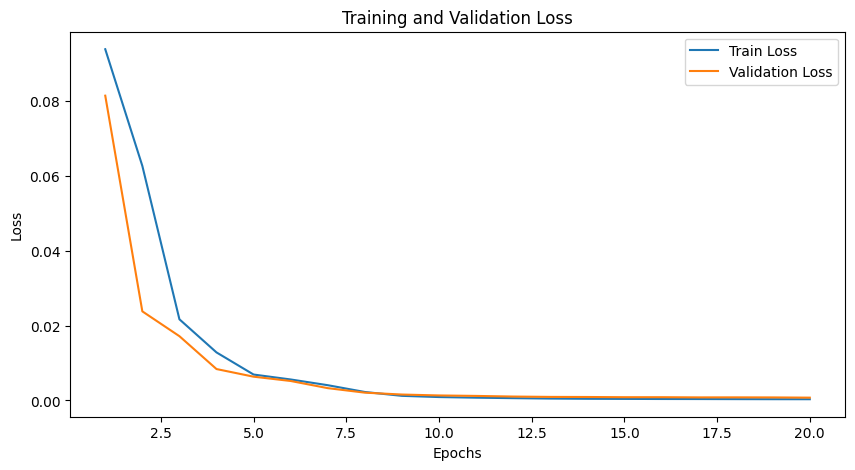

In [70]:
def plot_losses(train_losses, val_losses, epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses, epochs)

In [71]:
# Feature-based Anomaly Detection using VGG
vgg = models.vgg16(pretrained=True).features[:10].to(device)
vgg.eval()

def compute_feature_loss(original, reconstructed):
    with torch.no_grad():
        original_features = vgg(original)
        reconstructed_features = vgg(reconstructed)
    return torch.mean((original_features - reconstructed_features) ** 2)

In [72]:
# Anomaly Scoring
def anomaly_score(model, data_loader, device):
    model.eval()
    scores = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            reconstructed = model(images)
            loss = compute_feature_loss(images, reconstructed)
            scores.append(loss.item())
    return np.array(scores)

scores = anomaly_score(model, val_loader, device)
threshold = np.mean(scores) + 3 * np.std(scores)

In [73]:
def visualize_reconstruction_for_images(model, image_paths, device, threshold):
    model.eval()

    # Load and preprocess images
    images_array = []
    for path in image_paths:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (128, 128)) / 255.0  # Resize and normalize
        images_array.append(image)

    # Convert to Tensor
    images_tensor = torch.tensor(np.array(images_array)).permute(0, 3, 1, 2).float().to(device)

    # Get reconstructed images
    with torch.no_grad():
        reconstructed = model(images_tensor)

    fig, axes = plt.subplots(2, len(images_array), figsize=(16, 6))
    for i in range(len(images_array)):
        # Compute anomaly score
        score = compute_feature_loss(images_tensor[i:i + 1], reconstructed[i:i + 1]).item()
        label = "Defective" if score > threshold else "Good"

        # Convert tensors for visualization
        img_np = images_tensor[i].cpu().numpy()
        recon_np = reconstructed[i].cpu().detach().numpy()

        # Show original image in the first row
        axes[0, i].imshow(np.transpose(img_np, (1, 2, 0)))
        axes[0, i].axis("off")
        axes[0, i].set_title("Original")

        # Show reconstructed image with label in the second row
        axes[1, i].imshow(np.transpose(recon_np, (1, 2, 0)))
        axes[1, i].axis("off")
        axes[1, i].set_title(f"{label} (Score: {score:.4f})")

    plt.show()

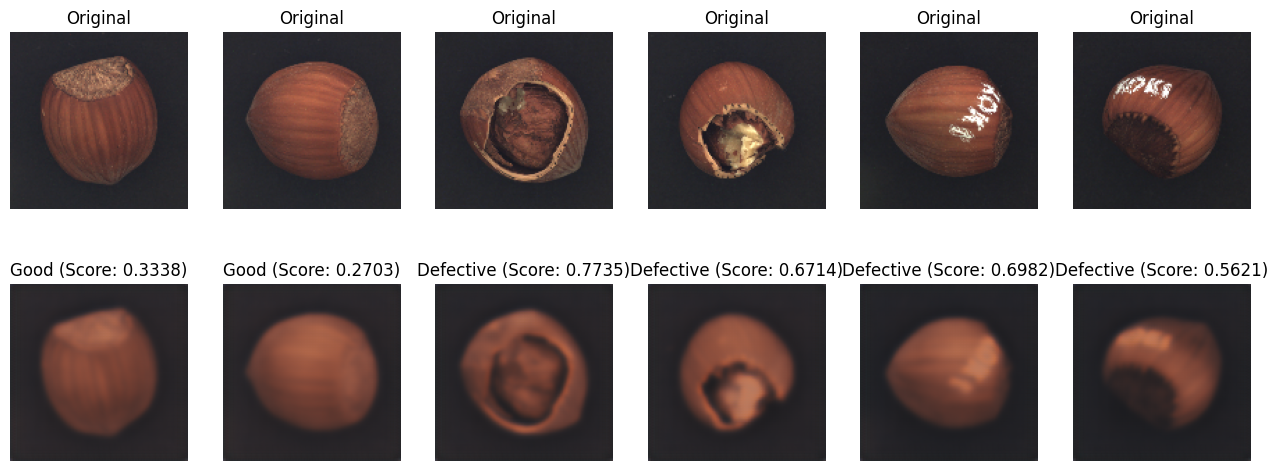

In [94]:
image_paths = [
      "/content/drive/My Drive/MVTecAD/hazelnut/test/good/022.png",
      "/content/drive/My Drive/MVTecAD/hazelnut/test/good/023.png",
      "/content/drive/My Drive/MVTecAD/hazelnut/test/crack/007.png",
      "/content/drive/My Drive/MVTecAD/hazelnut/test/crack/008.png",
      "/content/drive/My Drive/MVTecAD/hazelnut/test/print/000.png",
      "/content/drive/My Drive/MVTecAD/hazelnut/test/print/001.png",
    ]

visualize_reconstruction_for_images(model, image_paths, device, threshold)